<a href="https://colab.research.google.com/github/jjhbk/BLAIOT_JJ/blob/master/smart_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [242]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [243]:

data_dir=pathlib.Path('/content/drive/MyDrive/monitor_data')
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['vowel_a' 'cough_heavy' 'counting_fast' 'shallow_breath' 'deep_breath'
 'counting_normal' 'vowel_e' 'vowel_o' 'cough_shallow']


In [244]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 90
Number of examples per label: 10
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/monitor_data/deep_breath/breathing-deep8.wav', shape=(), dtype=string)


In [245]:
train_files = filenames[:72]
val_files = filenames[72: 72 + 9]
test_files = filenames[-9:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 72
Validation set size 9
Test set size 9


In [246]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  #print(_)
  return tf.squeeze(audio, axis=-1)

In [247]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

In [248]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [249]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

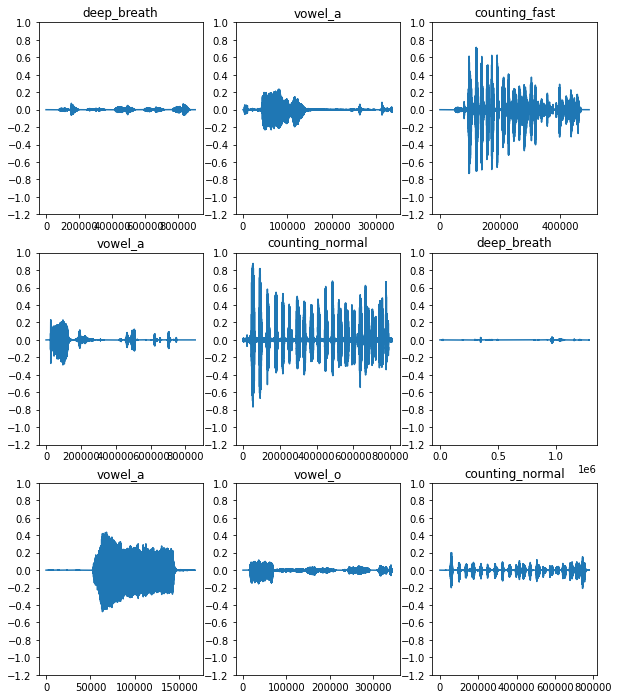

In [250]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()


In [266]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([2000000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=12750, frame_step=6400)
 # spectrogram = tf.signal.stft(
     # equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)+0.0001

  return spectrogram

In [267]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=48000))


Label: deep_breath
Waveform shape: (905216,)
Spectrogram shape: (311, 8193)
Audio playback


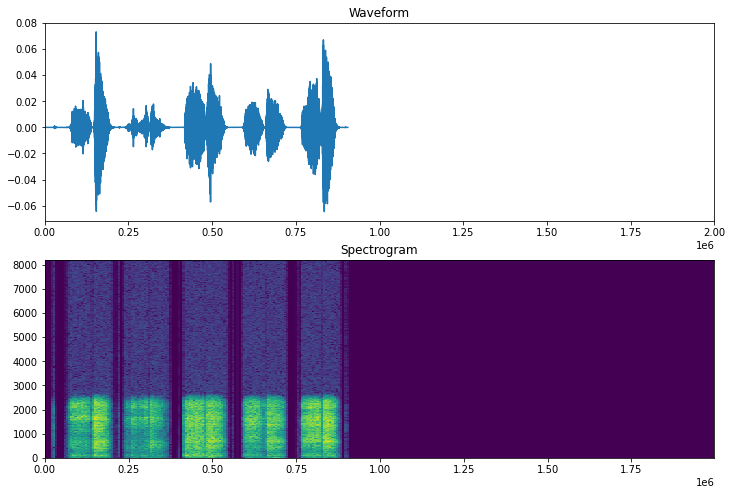

In [268]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(2000000, step=height-1750)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 2000000])
axes[1].set_title('Spectrogram')

plot_spectrogram(spectrogram.numpy(), axes[1])
plt.show()

In [269]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [270]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)


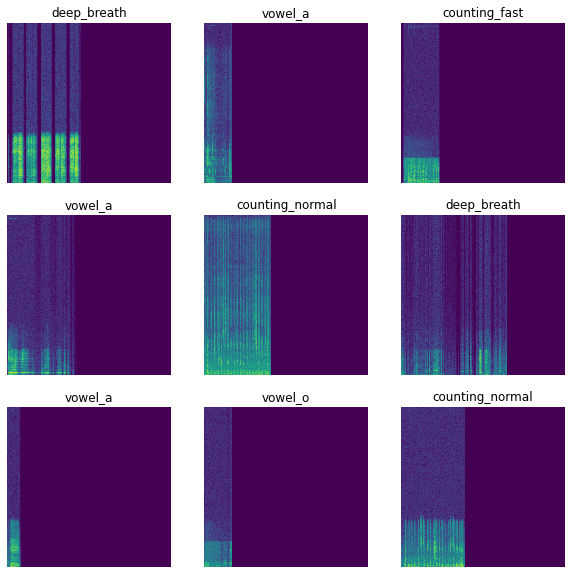

In [271]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [272]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [273]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [274]:
batch_size = 1
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)


In [275]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [276]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print(num_labels)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda y, _: y))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (311, 8193, 1)
9
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_4 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_18 (Normalizat (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)     

In [277]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [278]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),)

Epoch 1/10
72/72 [==============================] - 43s 585ms/step - loss: 2.3479 - accuracy: 0.0204 - val_loss: 2.1453 - val_accuracy: 0.2222
Epoch 2/10
72/72 [==============================] - 1s 14ms/step - loss: 2.1548 - accuracy: 0.2838 - val_loss: 2.1397 - val_accuracy: 0.0000e+00
Epoch 3/10
72/72 [==============================] - 1s 14ms/step - loss: 2.0089 - accuracy: 0.2095 - val_loss: 2.1095 - val_accuracy: 0.0000e+00
Epoch 4/10
72/72 [==============================] - 1s 18ms/step - loss: 1.8499 - accuracy: 0.3943 - val_loss: 2.0415 - val_accuracy: 0.1111
Epoch 5/10
72/72 [==============================] - 1s 13ms/step - loss: 1.7598 - accuracy: 0.3198 - val_loss: 1.8357 - val_accuracy: 0.2222
Epoch 6/10
72/72 [==============================] - 1s 15ms/step - loss: 1.6846 - accuracy: 0.4180 - val_loss: 1.9659 - val_accuracy: 0.1111
Epoch 7/10
72/72 [==============================] - 1s 14ms/step - loss: 1.4214 - accuracy: 0.4440 - val_loss: 2.0490 - val_accuracy: 0.2222
Epo

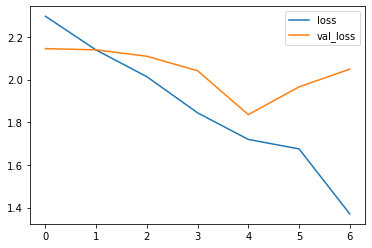

In [279]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [280]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [281]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 22%


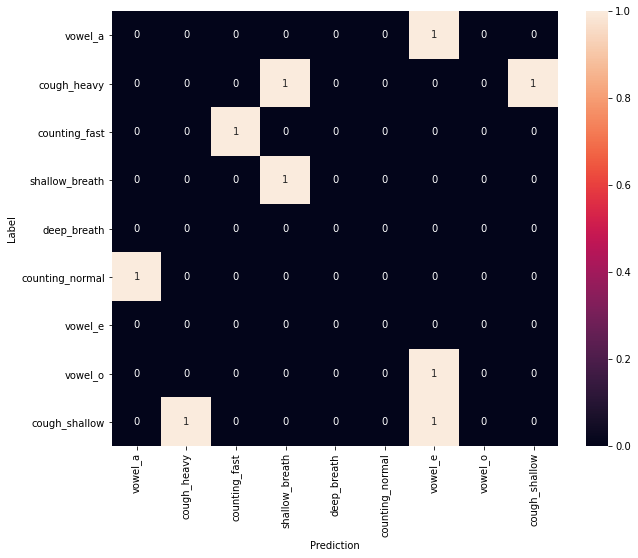

In [282]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

['vowel_a' 'cough_heavy' 'counting_fast' 'shallow_breath' 'deep_breath'
 'counting_normal' 'vowel_e' 'vowel_o' 'cough_shallow']
tf.Tensor(
[[-1.2793959  -0.24082437 -1.8751185   1.526587   -0.5384202  -1.8315097
  -1.7345028  -1.7247448   0.0093199 ]], shape=(1, 9), dtype=float32)
tf.Tensor(0.58053917, shape=(), dtype=float32)


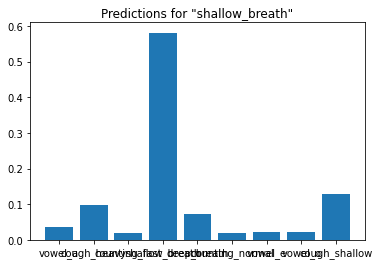

In [298]:
sample_file = data_dir/'shallow_breath/breathing-shallow5.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  prediction1=tf.nn.softmax(prediction[0])
  print(commands)
  print(prediction)
  print(max(prediction1))
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [289]:
saved_model_dir = ''
tf.saved_model.save(model, saved_model_dir)

INFO:tensorflow:Assets written to: assets


In [292]:
converter =tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [294]:
from google.colab import files
files.download('model.tflite')
#files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>